imports

In [1]:
import os
import sys
import time

import numpy as np
import torch
import pandas as pd
import librosa

import matplotlib.pyplot as plt

import torchnet.meter as tnt
from collections import OrderedDict
import importlib
from torchvision import transforms

sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '../models/'))
sys.path.append(os.path.join(os.getcwd(), '../datasets/'))

from types import SimpleNamespace

import ai8x

from msnoise import MSnoise
import msnoise
from signalmixer import signalmixer

from IPython.display import clear_output
from scipy.io.wavfile import write
import IPython

checkpoints

In [2]:
'''
trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_v2_0911Speed_DynAug","qat_best.pth.tar")             
mod = importlib.import_module("ai85net-kws20-v2")
model_file = "ai85net-kws20-v2"

'''
trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_v3_0911Speed_DynAug","qat_best.pth.tar")              
mod = importlib.import_module("ai85net-kws20-v3")
model_file = "ai85net-kws20-v3"

'''
trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_NAS_0911Speed_DynAug/","qat_best.pth.tar")
mod = importlib.import_module("ai85nasnet_kws20_res_1")
model_file = "ai85nasnet_kws20_res_1"
'''
dataset = importlib.import_module("kws20")

In [3]:
classes = ['up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one',
           'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'unknown']

model files

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working with device:", device)

ai8x.set_device(device=85, simulate=False, round_avg=False)
qat_policy = {'start_epoch': 10, 'weight_bits': 8, 'bias_bits': 8}
'''

model = mod.AI85KWS20Netv2(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)
'''

model = mod.AI85KWS20Netv3(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)

'''
model = mod.AI85NASNET_KWS20_RES_1(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=True, 
                           quantize_activation=False)
'''

checkpoint = torch.load(trained_checkpoint_path)

state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        k = k[7:]
    new_state_dict[k] = v
checkpoint['state_dict'] = new_state_dict

ai8x.fuse_bn_layers(model)
ai8x.initiate_qat(model, qat_policy)
model.load_state_dict(checkpoint['state_dict'], strict=False)


ai8x.update_model(model)

Working with device: cuda
Configuring device: MAX78000, simulate=False.


In [5]:
sn = SimpleNamespace()
sn.truncate_testset = False
sn.act_mode_8bit = False

In [6]:
# args = ('/data_ssd', Namespace(act_mode_8bit=False, activation_stats=[], avg_pool_rounding=False, batch_size=256, cnn='ai85kws20netv3', collate_fn=None, compress='policies/schedule_kws20.yaml', cpu=False, csv_prefix=None, data='/data_ssd', dataset='KWS_20', datasets_fn=<function KWS_20_get_datasets at 0x7f917f0f2040>, deterministic=True, device='cuda', dimensions=(128, 128, 1), display_confusion=True, display_embedding=False, display_prcurves=False, earlyexit_lossweights=None, earlyexit_thresholds=None, effective_test_size=1.0, effective_train_size=1.0, effective_valid_size=1.0, epochs=200, evaluate=False, extras=None, generate_sample=None, gpus=None, kd_distill_wt=0.5, kd_pretrained=False, kd_resume='', kd_start_epoch=0, kd_student_wt=0.5, kd_teacher=None, kd_teacher_wt=0.0, kd_temp=1.0, kernel_stats=False, labels=('up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'UNKNOWN'), load_model_path='', load_serialized=False, log_params_histograms=False, lr=0.001, masks_sparsity=False, momentum=0.9, name=None, nas=False, nas_kd_resume_from='', nas_policy='', nas_stage_transition_list=None, no_tensorboard=True, num_best_scores=1, num_classes=21, obj_detection=False, obj_detection_params=None, optimizer='Adam', out_fold_ratio=1, output_dir='logs', pretrained=False, print_freq=10, qat_policy='policies/qat_policy.yaml', qe_bits_accum=32, qe_bits_acts=8, qe_bits_wts=8, qe_calibration=None, qe_clip_acts=<ClipMode.NONE: 0>, qe_clip_n_stds=None, qe_config_file=None, qe_convert_pytorch=False, qe_dynamic=False, qe_mode=<LinearQuantMode.SYMMETRIC: 1>, qe_mode_acts=None, qe_mode_wts=None, qe_no_clip_layers=[], qe_no_quant_layers=[], qe_per_channel=False, qe_pytorch_backend='fbgemm', qe_save_fp_weights=False, qe_scale_approx_bits=None, qe_stats_file=None, quantize_eval=False, regression=False, reset_optimizer=False, resumed_checkpoint_path='', seed=None, sensitivity=None, sensitivity_range=[0.0, 0.95, 0.05], shap=0, show_train_accuracy='last_batch', sparsity_perf=False, summary=None, summary_filename='model', tblog=False, thinnify=False, truncate_testset=False, use_bias=False, validation_split=0.1, visualize_fn=<function visualize_data at 0x7f8fface3790>, weight_decay=0.0, workers=4))
_, test_dataset = dataset.KWS_20_get_datasets( ('/data_ssd/', sn), load_train=False, load_test=True)
_, test_noise = msnoise.MSnoise_get_datasets(('/data_ssd/', sn), load_train=False, load_test=True)

No key `stretch` in input augmentation dictionary! Using defaults: [Min: 0.8, Max: 1.3]



Processing test...
test set: 33015 elements
Class up (# 31): 1275 elements
Class down (# 5): 1218 elements
Class left (# 15): 1236 elements
Class right (# 23): 1188 elements
Class stop (# 27): 1233 elements
Class go (# 11): 1206 elements
Class yes (# 34): 1257 elements
Class no (# 19): 1215 elements
Class on (# 21): 1188 elements
Class off (# 20): 1206 elements
Class one (# 22): 1197 elements
Class two (# 30): 1272 elements
Class three (# 28): 1215 elements
Class four (# 10): 1200 elements
Class five (# 7): 1335 elements
Class six (# 26): 1182 elements
Class seven (# 24): 1218 elements
Class eight (# 6): 1224 elements
Class nine (# 18): 1224 elements
Class zero (# 35): 1254 elements
Class UNKNOWN: 8472 elements
torch.Size([56372, 128, 128])


Class AirConditioner, 0
Number of elements in class AirConditioner: 1224
AirConditioner: 0
Class AirportAnnouncements, 1
Number of elements in class AirportAnnouncements: 898
AirportAnnouncements: 1
Class Babble, 2
Number of elements in class Bab

In [7]:
originals = list(range(0, len(test_dataset), 3))
test_dataset.data = test_dataset.data[originals]
test_dataset.targets = test_dataset.targets[originals]

In [8]:
noise_dict = {}

for idx, i in enumerate(test_noise.classes):

    if list(test_noise.targets).count(idx) == 0:
        continue

    else:
        noise_dict[i] = idx

noise_list = noise_dict.keys()
noise_list = list(noise_list)
noise_list.append('WhiteNoise')

In [9]:
noise_list

['AirConditioner',
 'AirportAnnouncements',
 'Babble',
 'CopyMachine',
 'Munching',
 'NeighborSpeaking',
 'ShuttingDoor',
 'Typing',
 'VacuumCleaner',
 'TradeShow',
 'WhiteNoise']

### Evaluation

In [10]:
def evaluate(db, noise, noise_kind):

    if (noise == True) and (noise_kind == None):
        print('Noise kind is not specified. Noise will not be applied.')
        noise = False

    model.eval()
    model.to(device)
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes), 5)))
    outputs_all = np.zeros((len(test_dataset), 21))
    targets_all = np.zeros((len(test_dataset)))

    transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
    
    if noise:

        if (noise_kind == 'WhiteNoise'):

            mixed_signals = signalmixer(test_dataset, noise = True, noise_dataset = None, snr = db, noise_kind = noise_kind, 
                                        quantized_noise = False, transform = None)
            mixed_signals_loader = torch.utils.data.DataLoader(mixed_signals, batch_size = 256)

        else:
            noise_dataset = msnoise.MSnoise(root = '/data_ssd', classes = [noise_kind], d_type = 'test', remove_unknowns=True,
                        transform=None, quantize=False, download=False)

            mixed_signals = signalmixer(test_dataset, noise = True, noise_dataset = noise_dataset, snr = db, noise_kind = noise_kind, 
                    quantized_noise = False, transform = None)
            
            mixed_signals_loader = torch.utils.data.DataLoader(mixed_signals, batch_size = 256)
    else:
        mixed_signals_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 256)
        
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(mixed_signals_loader):
            write(f'/home/merveeyuboglu/Github/ai8x-training/codes/audios/mixed_{noise_kind}_{db}.wav', 16384, np.array(inputs[0]).flatten('F'))
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            classerr.add(outputs, targets)

            print("Batch: [",batch_idx*256 ,"/", len(test_dataset),"]")
            acc = classerr.value()[0]
            print("Accuracy: ", acc)
            outputs_all[batch_idx*256:batch_idx*256+len(inputs)] = outputs.cpu().numpy()
            targets_all[batch_idx*256:batch_idx*256+len(inputs)] = targets.cpu().numpy()
            
    print("Total Accuracy: ", acc)
    return acc

In [11]:
def snr_testing(noise = False, noise_kind = None):

    if noise == False:
        db = None

    time_s = time.time()
    print("Started evaluating :", trained_checkpoint_path)

    if noise == False:
        accuracies = np.zeros(1)
        snr = np.zeros(1)

        accuracies[0] = evaluate(db, noise, noise_kind)
        snr[0] = None
        
        dur = time.time() - time_s
        print(f'Finished in {dur:.3f} seconds.')
        return accuracies, snr
    
    accuracies = np.zeros(36)
    snr = np.zeros(36)

    for idx, db in enumerate(range(-5,31)):
        print("Evaluating SNR levels of", db)
        accuracies[idx] = evaluate(db, noise, noise_kind)
        snr[idx] = db
    
    dur = time.time() - time_s
    print(f'Finished in {dur:.3f} seconds.')
    return accuracies, snr

In [12]:
def benchmark(noise_kinds):

    num = len(noise_kinds) + 1

    snr = np.zeros((num, 36))
    accuracies = np.zeros((num, 36))

    for idx, n in enumerate(noise_kinds):

        print(f'{n} Noise Evaluation')
        
        accuracies[idx], snr[idx] = snr_testing(noise = True, noise_kind = n)

    accuracies[-1], snr[-1] = snr_testing(noise = False)

    return accuracies, snr

In [64]:
accuracies_w, snr_w = benchmark(noise_list)

AirConditioner Noise Evaluation
Started evaluating : /home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_v3_0911Speed_DynAug/qat_best.pth.tar
Evaluating SNR levels of -5


torch.Size([56372, 128, 128])


Class AirConditioner, 0
Number of elements in class AirConditioner: 1224
AirConditioner: 0
Number of elements in class unknown: 8206
[0]


Batch: [ 0 / 11005 ]
Accuracy:  10.15625
Batch: [ 256 / 11005 ]
Accuracy:  7.8125
Batch: [ 512 / 11005 ]
Accuracy:  6.1197916666666625
Batch: [ 768 / 11005 ]
Accuracy:  8.984375
Batch: [ 1024 / 11005 ]
Accuracy:  21.875
Batch: [ 1280 / 11005 ]
Accuracy:  25.325520833333336
Batch: [ 1536 / 11005 ]
Accuracy:  25.11160714285714
Batch: [ 1792 / 11005 ]
Accuracy:  25.78125
Batch: [ 2048 / 11005 ]
Accuracy:  25.82465277777778
Batch: [ 2304 / 11005 ]
Accuracy:  24.0234375
Batch: [ 2560 / 11005 ]
Accuracy:  24.644886363636363
Batch: [ 2816 / 11005 ]
Accuracy:  25.1953125
Batch: [ 3072 / 11005 ]
Accuracy:  25.661057692307686
Batch: [ 3328 / 11005 ]
Accuracy:  24.190848214285708
Batch: [ 3584 / 11005 ]
Accuracy:  23.09895833333333
Batch: [ 3840 / 11005 ]
Accuracy:  23.7548828125
Batch: [ 4096 / 11005 ]
Accuracy:  24.70128676470

### Examples

In [11]:
def evaluate_voice(db, noise, noise_kind):

    if (noise == True) and (noise_kind == None):
        print('Noise kind is not specified. Noise will not be applied.')
        noise = False

    model.eval()
    model.to(device)
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes), 5)))
    outputs_all = np.zeros((len(test_dataset), 21))
    targets_all = np.zeros((len(test_dataset)))

    transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
    
    if noise:

        if (noise_kind == 'WhiteNoise'):

            mixed_signals = signalmixer(test_dataset, noise = True, noise_dataset = None, snr = db, noise_kind = noise_kind, 
                                        quantized_noise = False, transform = None)
            mixed_signals_loader = torch.utils.data.DataLoader(mixed_signals, batch_size = 256)

        else:
            noise_dataset = msnoise.MSnoise(root = '/data_ssd', classes = [noise_kind], d_type = 'test', remove_unknowns=True,
                        transform=None, quantize=False, download=False)

            mixed_signals = signalmixer(test_dataset, noise = True, noise_dataset = noise_dataset, snr = db, noise_kind = noise_kind, 
                    quantized_noise = False, transform = None)
            
            mixed_signals_loader = torch.utils.data.DataLoader(mixed_signals, batch_size = 256)
    else:
        mixed_signals_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 256)
        
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(mixed_signals_loader):
            write(f'/home/merveeyuboglu/Github/ai8x-training/codes/audios/mixed_{noise_kind}_{db}.wav', 16384, np.array(inputs[0]).flatten('F'))
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            classerr.add(outputs, targets)

            print("Batch: [",batch_idx*256 ,"/", len(test_dataset),"]")
            acc = classerr.value()[0]
            print("Accuracy: ", acc)
            outputs_all[batch_idx*256:batch_idx*256+len(inputs)] = outputs.cpu().numpy()
            targets_all[batch_idx*256:batch_idx*256+len(inputs)] = targets.cpu().numpy()
            
    print("Total Accuracy: ", acc)
    return acc

In [24]:
evaluate_voice(20, True, 'WhiteNoise')

Batch: [ 0 / 11005 ]
Accuracy:  89.0625
Batch: [ 256 / 11005 ]
Accuracy:  84.1796875
Batch: [ 512 / 11005 ]
Accuracy:  84.11458333333334
Batch: [ 768 / 11005 ]
Accuracy:  82.421875
Batch: [ 1024 / 11005 ]
Accuracy:  84.0625
Batch: [ 1280 / 11005 ]
Accuracy:  86.1328125
Batch: [ 1536 / 11005 ]
Accuracy:  87.33258928571428
Batch: [ 1792 / 11005 ]
Accuracy:  88.4765625
Batch: [ 2048 / 11005 ]
Accuracy:  88.75868055555556
Batch: [ 2304 / 11005 ]
Accuracy:  86.4453125
Batch: [ 2560 / 11005 ]
Accuracy:  87.0028409090909
Batch: [ 2816 / 11005 ]
Accuracy:  87.53255208333334
Batch: [ 3072 / 11005 ]
Accuracy:  88.0108173076923
Batch: [ 3328 / 11005 ]
Accuracy:  88.28125
Batch: [ 3584 / 11005 ]
Accuracy:  87.65625
Batch: [ 3840 / 11005 ]
Accuracy:  87.109375
Batch: [ 4096 / 11005 ]
Accuracy:  87.61488970588235
Batch: [ 4352 / 11005 ]
Accuracy:  87.6953125
Batch: [ 4608 / 11005 ]
Accuracy:  87.95230263157895
Batch: [ 4864 / 11005 ]
Accuracy:  88.1640625
Batch: [ 5120 / 11005 ]
Accuracy:  88.467261

90.00454338936848

/home/merveeyuboglu/Github/ai8x-training/venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Frequency (Hz)')

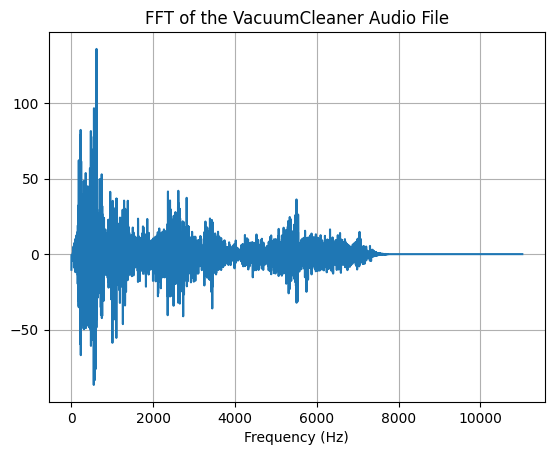

In [23]:
vacuumcleaner, vc_fs = librosa.load("/data_ssd/MSnoise/raw/noise_test/VacuumCleaner_1.wav")

plt.plot(np.fft.fft(vacuumcleaner[:vc_fs])[:int(vc_fs/2)])
plt.title('FFT of the VacuumCleaner Audio File')
plt.grid()
plt.xlabel('Frequency (Hz)')

Text(0.5, 0, 'Frequency (Hz)')

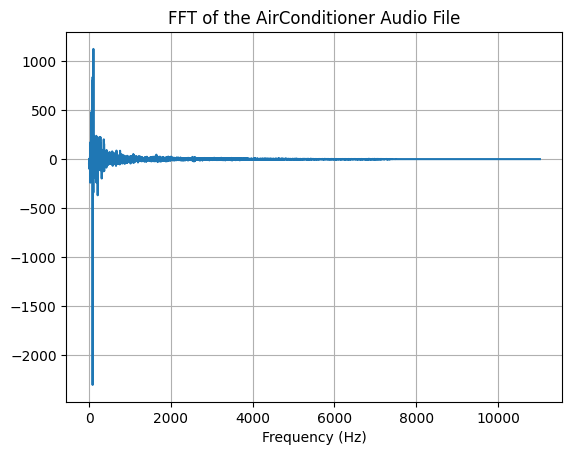

In [25]:
airconditioner, ac_fs = librosa.load("/data_ssd/MSnoise/raw/noise_test/AirConditioner_1.wav")

plt.plot(np.fft.fft(airconditioner[:ac_fs])[:int(ac_fs/2)])
plt.title('FFT of the AirConditioner Audio File')
plt.grid()
plt.xlabel('Frequency (Hz)')

## Plots

In [65]:
snr = range(-5,31)

csv ={}

for idx, i in enumerate(noise_list):
    csv[i] = accuracies_w[idx]
    
csv_list = []

csv_list.append(['raw', 'None', accuracies_w[-1][0]])
for i in csv.keys():
    for idx, j in enumerate(csv[i]):
        csv_list.append([i, snr[idx], j])

df = pd.DataFrame(csv_list, columns = ['Type', 'SNR (dB)', f'{model_file}'])

In [66]:
df

,Type,SNR (dB),ai85net-kws20-v3
0,raw,None,90.804180
1,AirConditioner,-5,30.895048
2,AirConditioner,-4,34.938664
3,AirConditioner,-3,39.373012
4,AirConditioner,-2,43.952749
...,...,...,...
392,WhiteNoise,26,90.177192
393,WhiteNoise,27,90.304407
394,WhiteNoise,28,90.277147
395,WhiteNoise,29,90.249886


In [67]:
if os.path.exists('/home/merveeyuboglu/Github/ai8x-training/codes/acc.csv'):
    current = pd.read_csv('/home/merveeyuboglu/Github/ai8x-training/codes/acc.csv', decimal=',', sep=';')
    if model_file in current.columns:
        print(f'This model file ({model_file}) already exists!')
    else:
        current[model_file] = list(df[model_file].values)
        current.to_csv('acc.csv', sep=';', decimal=',', index=False)

else:
    df.to_csv('acc.csv', sep=';', decimal=',', index=False)

In [68]:
data_files = pd.read_csv('/home/merveeyuboglu/Github/ai8x-training/codes/acc.csv', decimal=',', sep=';')

In [69]:
data_files

,Type,SNR (dB),ai85nasnet_kws20_res_1,ai85net-kws20-v2,ai85net-kws20-v3
0,raw,NaN,93.766470,92.021808,90.804180
1,AirConditioner,-5.0,44.716038,34.711495,30.895048
2,AirConditioner,-4.0,49.495684,39.663789,34.938664
3,AirConditioner,-3.0,55.665607,44.906861,39.373012
4,AirConditioner,-2.0,59.391186,50.486143,43.952749
...,...,...,...,...,...
392,WhiteNoise,26.0,93.357565,91.222172,90.177192
393,WhiteNoise,27.0,93.348478,91.194911,90.304407
394,WhiteNoise,28.0,93.466606,91.267606,90.277147
395,WhiteNoise,29.0,93.430259,91.276692,90.249886


In [70]:
def plot(model_number):

    accuracies_values = {}

    for noise in noise_list:
        acc_list = []
        for idx, i in enumerate(data_files['Type'].values[1:]): 
            if i == noise:
                acc_list.append(data_files[model_number][1:][idx+1])
        accuracies_values[noise] = acc_list

    return accuracies_values

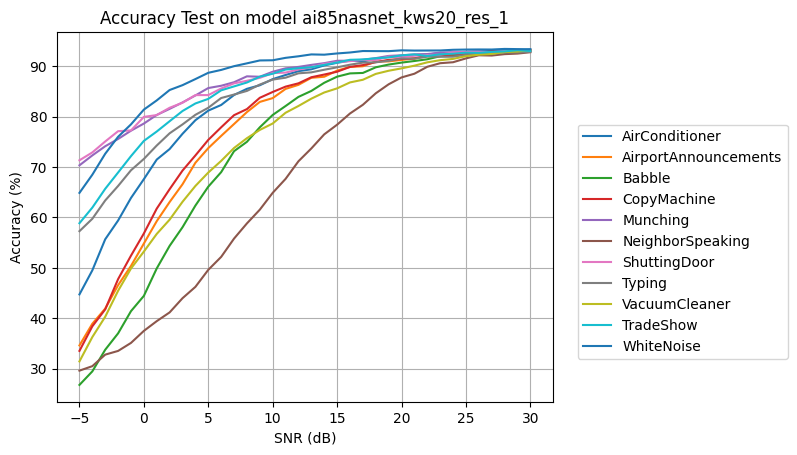

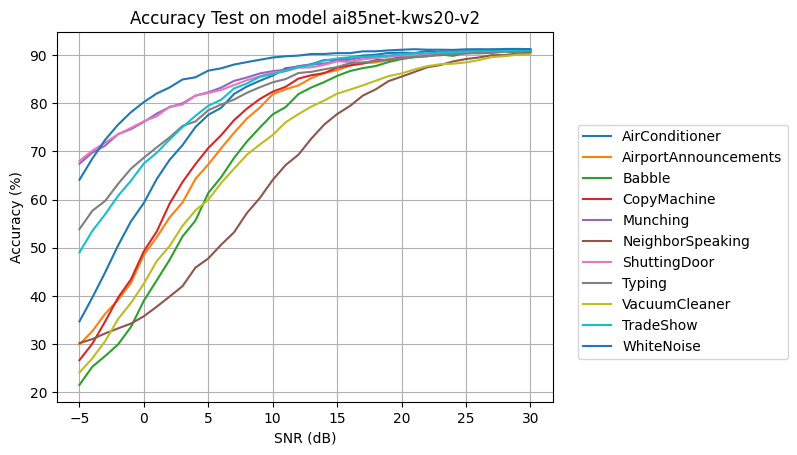

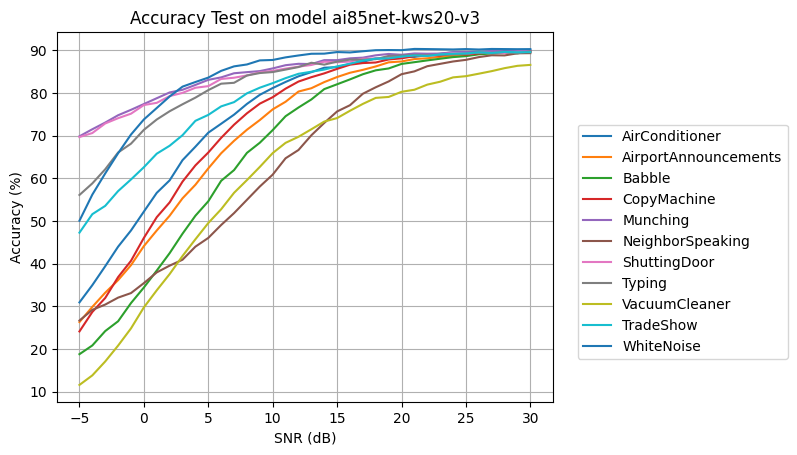

In [71]:
snr = range(-5,31)

for model_num in data_files.columns[2:]:
    accuracies_values = plot(model_num)
    plt.figure()
    plt.grid()
    for noise in noise_list:
        plt.title(f'Accuracy Test on model {model_num}') #duzelecek
        plt.xlabel('SNR (dB)')
        plt.ylabel('Accuracy (%)')
        plt.plot(snr, accuracies_values[noise])

    plt.legend(noise_list, bbox_to_anchor=(1.05, 0.75),
                         loc='upper left', borderaxespad=0.)

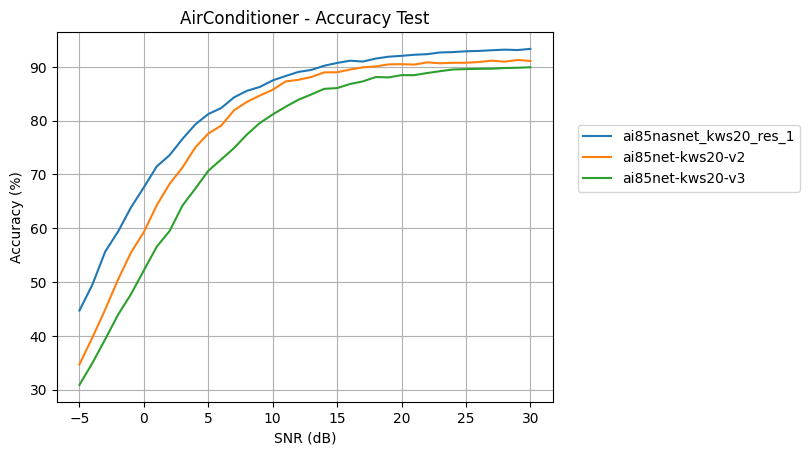

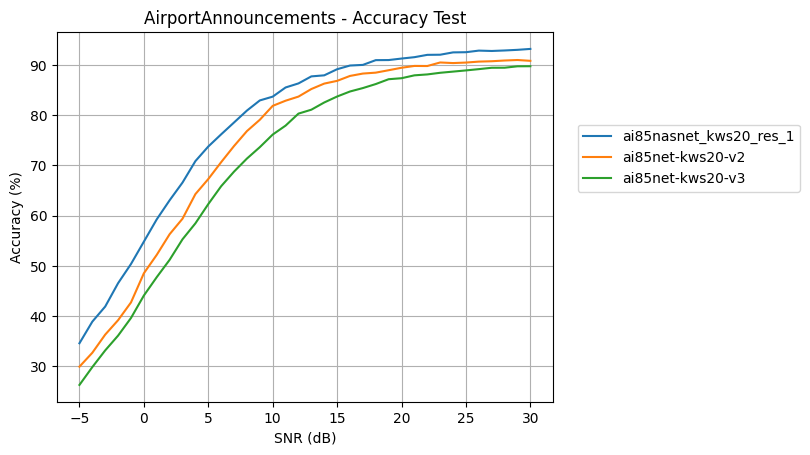

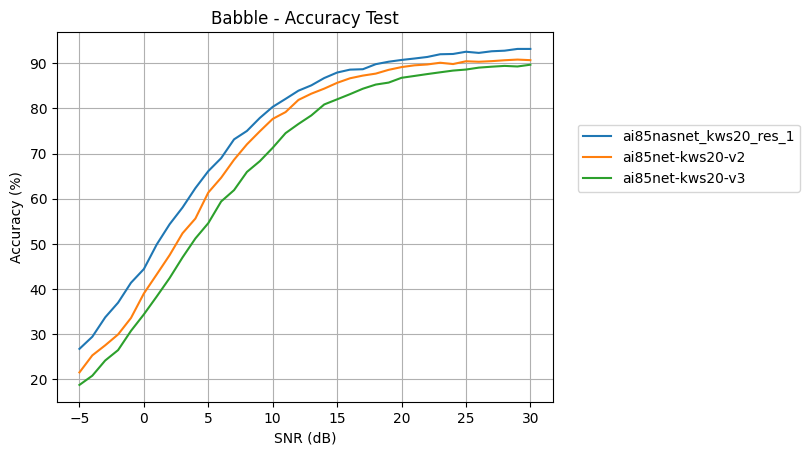

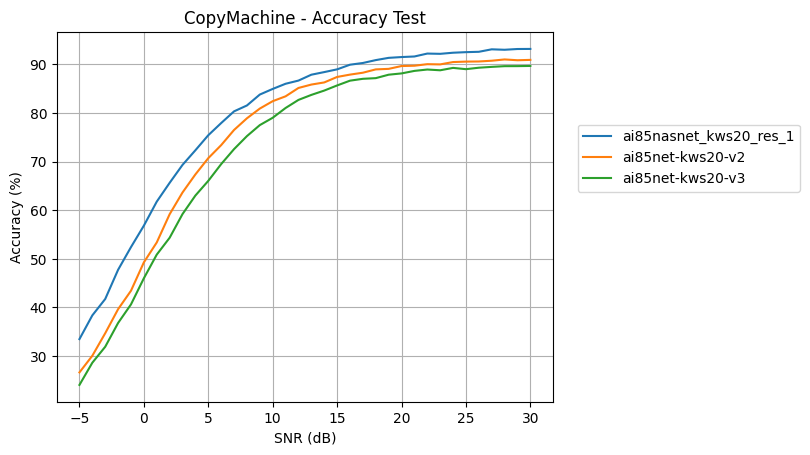

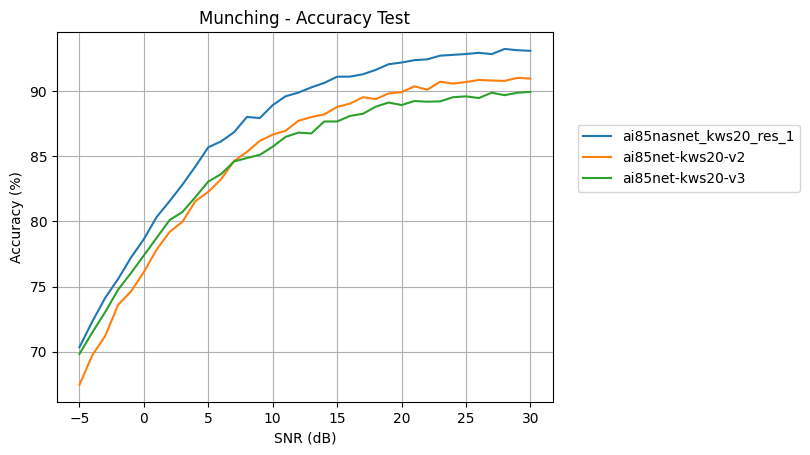

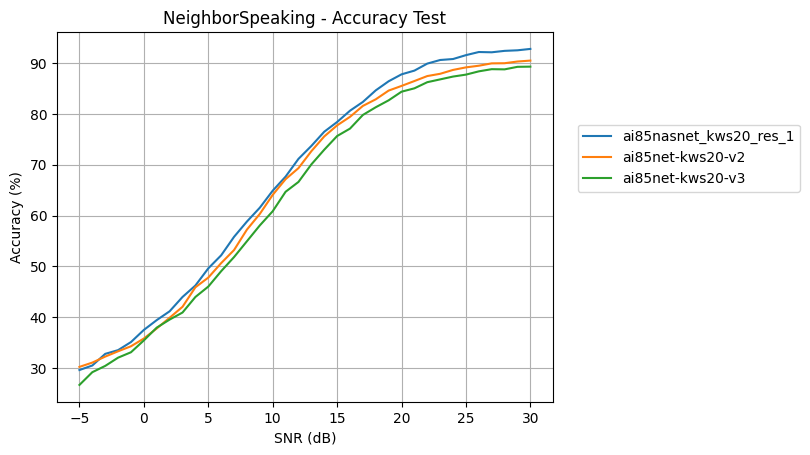

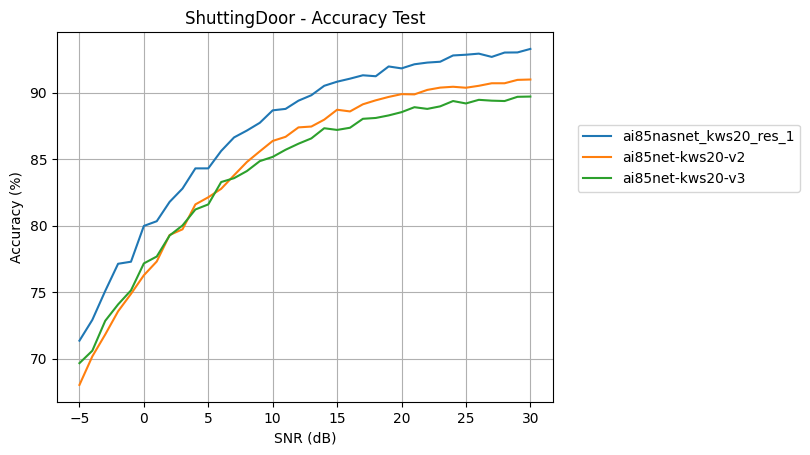

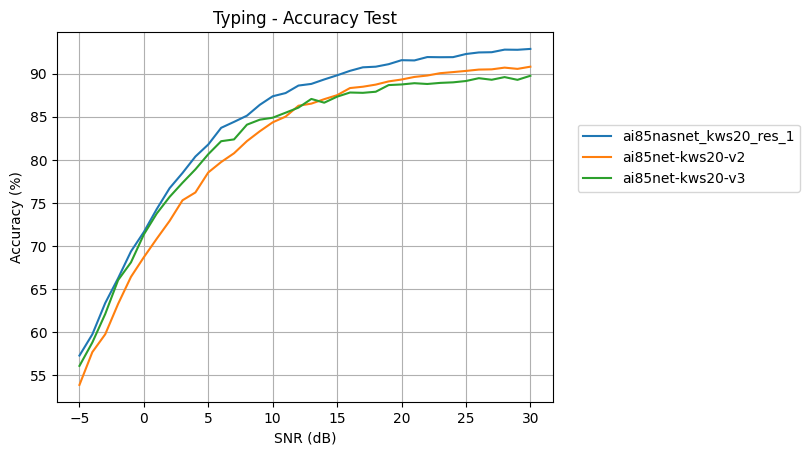

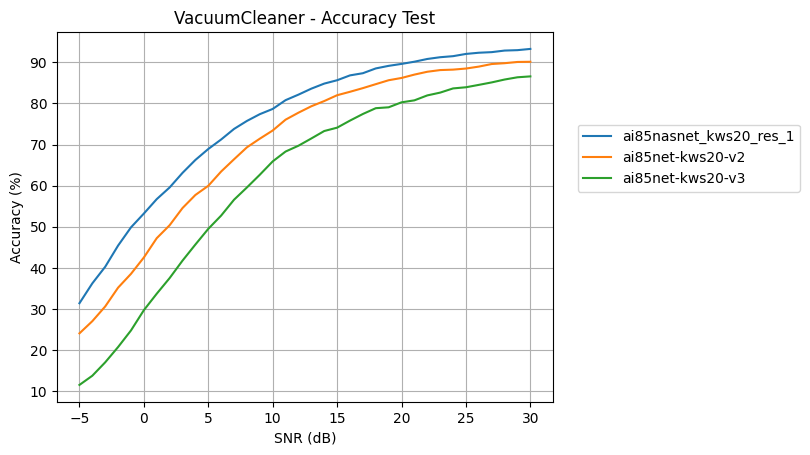

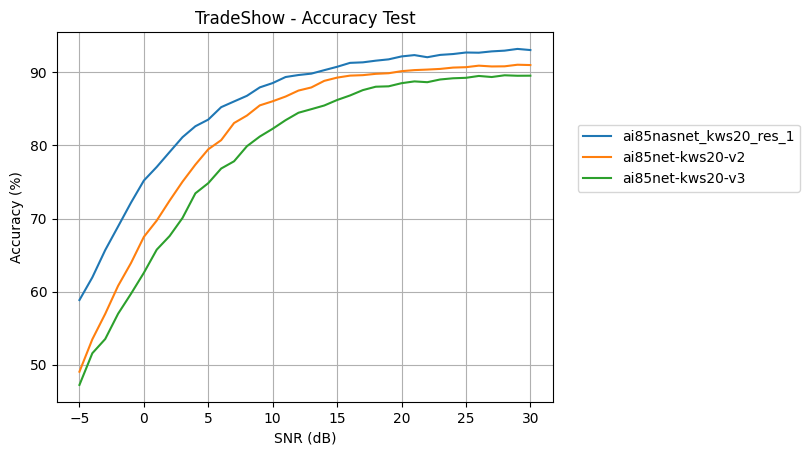

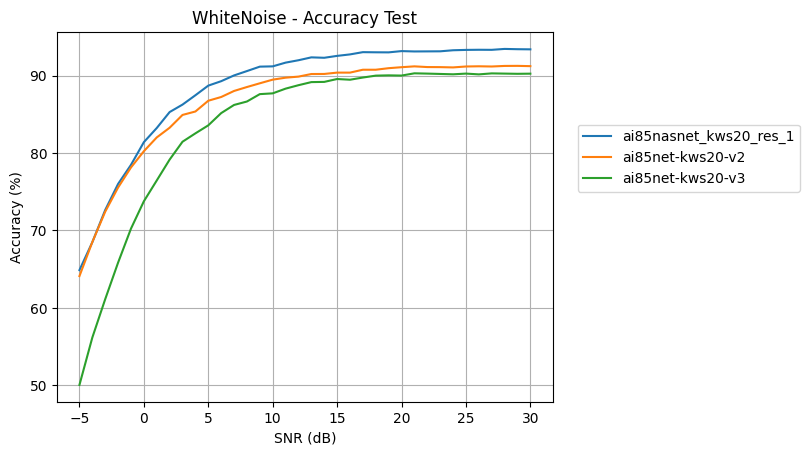

In [72]:
snr = range(-5,31)
acc_list = []
for model_num in data_files.columns[2:]:
    acc_list.append(plot(model_num))
    
for noise in noise_list:
    plt.figure()
    plt.grid()
    plt.title(f'{noise} - Accuracy Test')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy (%)')
    for model in acc_list:
        plt.plot(snr , model[noise])

    plt.legend(data_files.columns[2:], bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)